# Proces oraz wizualizacja tworzenia modelu klasyfikującego zdarzenia dźwiękowe w środowisku domowym
Autorzy
- Julia Jelska
- Piotr Muzyka
- Paweł Niewiarowski

# Cel projektu
Celem tego projektu jest zbudowanie modelu uczenia maszynowego, który potrafi rozpoznawać i klasyfikować różne zdarzenia dźwiękowe nagrywane w warunkach domowych. \
Proces obejmuje kilka kluczowych etapów:
- **Przygotowanie danych** – nagrania dźwięków pochodzące z konkretnych, predefiniowanych klas (np. dzwonek, odkurzacz, pukanie do drzwi) są oczyszczane i segmentowane na próbki odpowiednie do analizy.
- **Ekstrakcja cech** – z nagrań wyodrębniamy istotne cechy sygnału, takie jak MFCC, energia, chroma czy spektrum częstotliwości, które umożliwiają modelowi rozróżnianie klas.
- **Budowa modelu** – na podstawie przygotowanych danych trenujemy klasyfikator (np. Random Forest, SVM lub sieć neuronową), który uczy się rozpoznawać konkretne zdarzenia dźwiękowe.
- **Wizualizacja wyników** – wyniki klasyfikacji prezentujemy w postaci macierzy pomyłek, krzywej uczenia oraz innych wykresów, co pozwala lepiej zrozumieć działanie modelu i zidentyfikować klasy sprawiające największą trudność.

# Wykorzystane zależności
- [librosa](https://librosa.org/)
- [numpy](https://numpy.org/)
- [sklearn](https://scikit-learn.org/)

In [4]:
import os
import librosa
import numpy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler

## Załadowanie danych z systemu plików
Załadowanie d danych testowych oraz trenig

In [5]:
DATA_DIR: str = '../../dataset/'

In [6]:
labels: list = []
features: list = []

In [7]:
for label in os.listdir(DATA_DIR):
    class_dir = os.path.join(DATA_DIR, label)

    if not os.path.isdir(class_dir):
        continue

    for filename in os.listdir(class_dir):
        if filename.endswith(".wav"):
            file_path = os.path.join(class_dir, filename)

            labels_ys, sr = librosa.load(file_path, sr=None)
            mfcc = librosa.feature.mfcc(y=labels_ys, sr=sr, n_mfcc=40)
            mfcc_mean = numpy.mean(mfcc.T, axis=0)

            features.append(mfcc_mean)
            labels.append(label)

/home/muzykos/Documents/Github/Projekt_badawczy_System_rozpoznawania_zdarzen_dzwiekowych_w_przestrzeni_domowej/.venv/lib/python3.12/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [8]:
features_xs = numpy.array(features)
labels_ys = numpy.array(labels)

In [9]:
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(labels_ys)

x_train, x_test, y_train, y_test = train_test_split(features_xs, y_enc, test_size=1/3, random_state=42, stratify=y_enc)

In [10]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Klasyfikator SVM

### Parametry konfiguracji klasyfikatora SVM
- **C**: określa jak mocno model karze błędy; im większe C, tym bardziej model dąży do idealnego dopasowania
- **kernel**: rodzaj funkcji jądra; RBF jest najpopularniejsze dla nieliniowych danych
- **degree**: ma znaczenie tylko dla jądra "poly", przy RBF jest ignorowane
- **gamma**: określa wpływ pojedynczego punktu na granicę decyzji; wartość "scale" oznacza automatyczne obliczenie
- **coef0**: używane tylko przy jądrach "poly" i "sigmoid"
- **shrinking**: czy używać heurystyki przyspieszającej obliczenia
- **probability**: umożliwia obliczanie prawdopodobieństw klas (predict_proba); spowalnia trenowanie
- **tol**: tolerancja błędu, przy której algorytm kończy iteracje
- **cache_size**: ilość pamięci (w MB) przeznaczona na cache jądra
- **class_weight**: pozwala ustawić różne wagi dla klas, np. "balanced" przy nierównych zbiorach
- **verbose**: włącza logowanie pracy algorytmu (głównie do debugowania)
- **max_iter**: maksymalna liczba iteracji treningu; -1 oznacza brak limitu
- **decision_function_shape**: sposób obsługi wielu klas: "ovr" (one-vs-rest) lub "ovo" (one-vs-one)
- **break_ties**: jeśli True, rozstrzyga remisy (działa tylko przy decision_function_shape="ovr")
- **random_state**: ustawia ziarno losowości, aby wyniki były powtarzalne

In [11]:
clf = SVC(kernel="rbf", probability=True)
clf.fit(x_train_scaled, y_train)
y_pred = clf.predict(x_test_scaled)

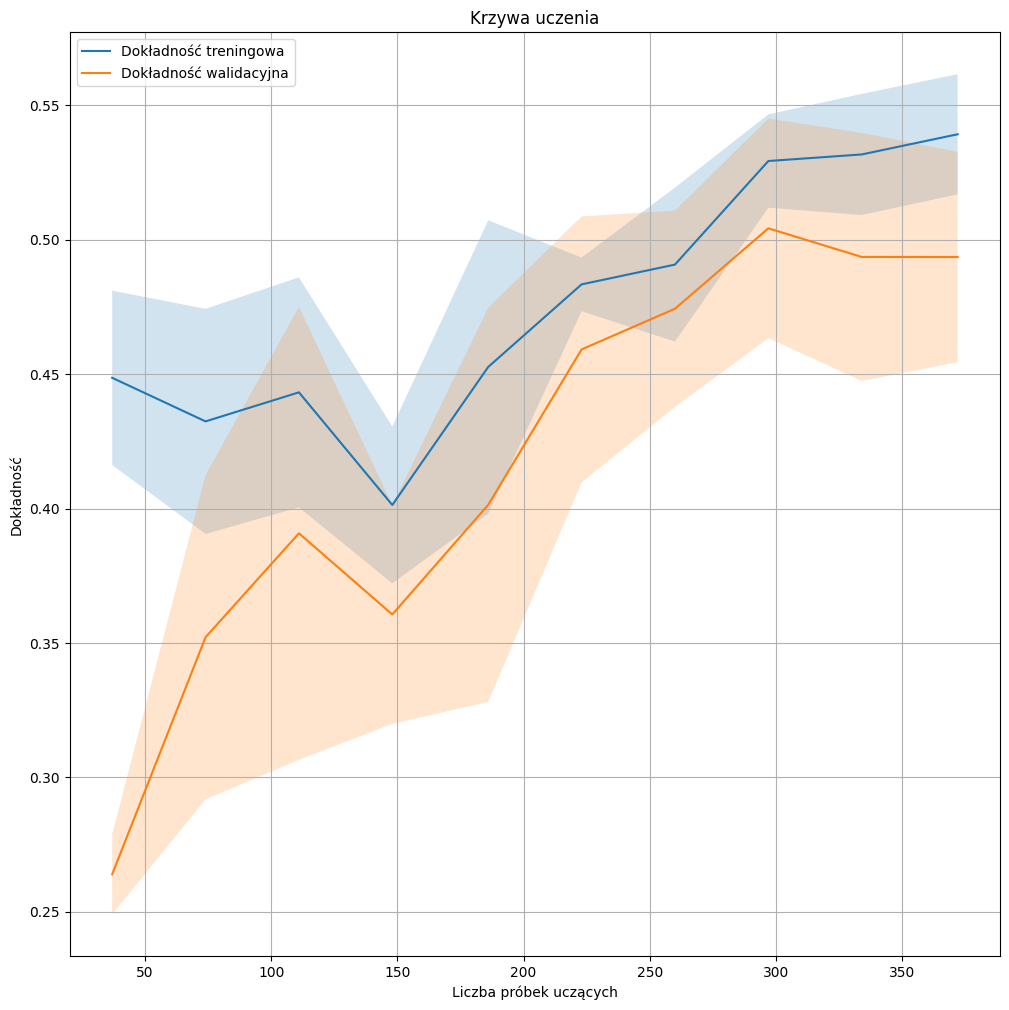

In [12]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=clf,
    X=x_train,
    y=y_train,
    cv=5,
    train_sizes=numpy.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = numpy.mean(train_scores, axis=1)
train_std = numpy.std(train_scores, axis=1)
val_mean = numpy.mean(val_scores, axis=1)
val_std = numpy.std(val_scores, axis=1)

plt.figure(figsize=(12, 12))
plt.plot(train_sizes, train_mean, label="Dokładność treningowa")
plt.plot(train_sizes, val_mean, label="Dokładność walidacyjna")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title("Krzywa uczenia")
plt.xlabel("Liczba próbek uczących")
plt.ylabel("Dokładność")
plt.legend()
plt.grid(True)
plt.show()

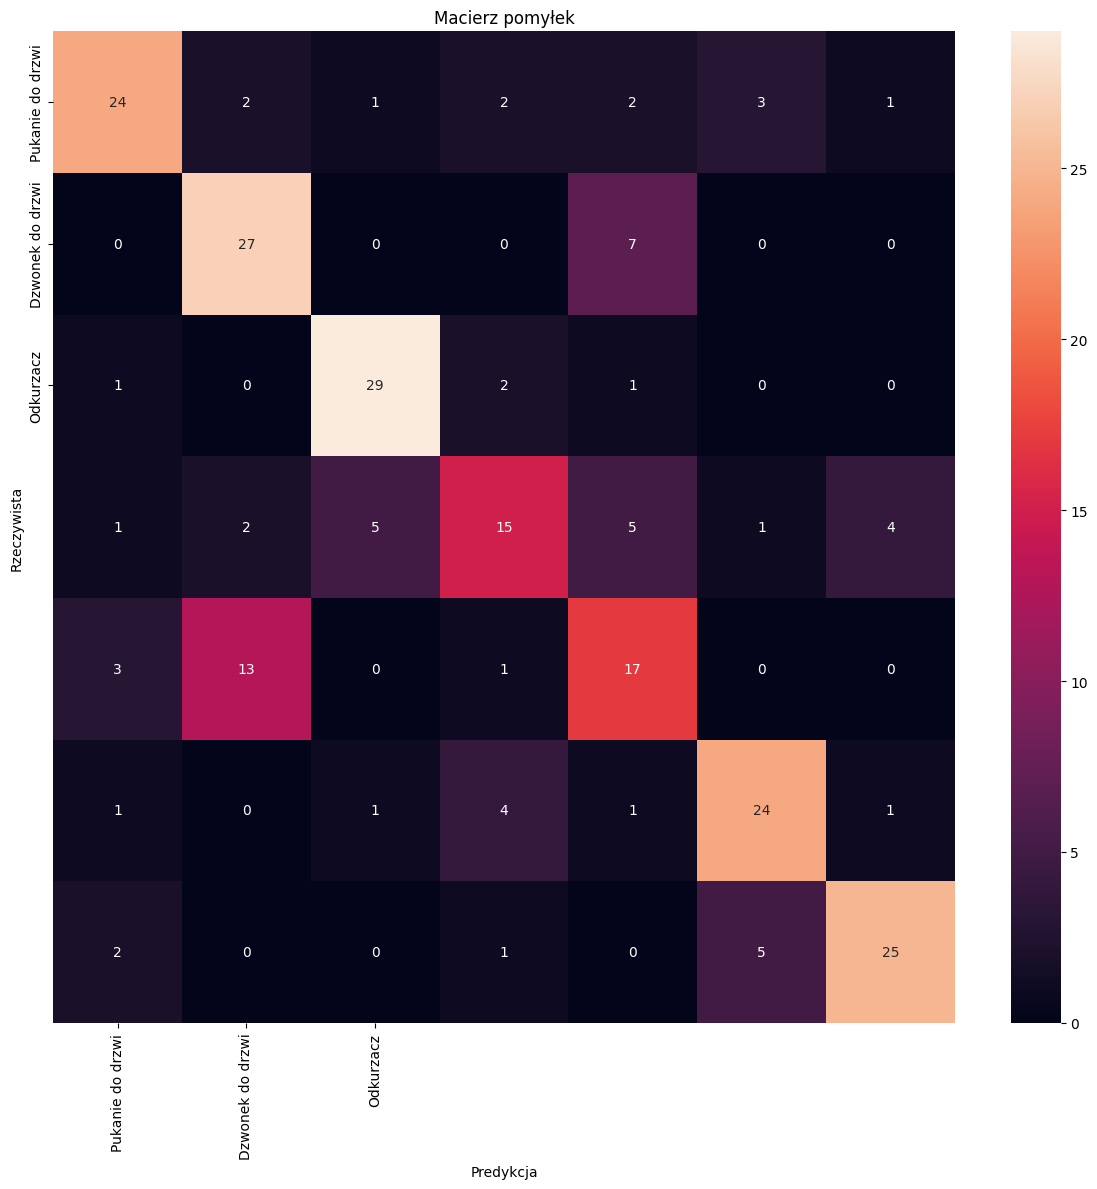

In [13]:
plt.figure(figsize=(12, 12))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    xticklabels=["Pukanie do drzwi", "Dzwonek do drzwi", "Odkurzacz"],
    yticklabels=["Pukanie do drzwi", "Dzwonek do drzwi", "Odkurzacz"],
)

plt.xlabel("Predykcja")
plt.ylabel("Rzeczywista")
plt.title("Macierz pomyłek")
plt.tight_layout()
plt.show()